Multi Layer Perceptron - Speaker Independent


In [1]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

In [2]:
# clone dataset from github
!git clone https://github.com/miftanurfarid/speech_emotion_recognition/

Cloning into 'speech_emotion_recognition'...
remote: Enumerating objects: 6987, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 6987 (delta 77), reused 116 (delta 67), pack-reused 6861
Receiving objects: 100% (6987/6987), 745.63 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (397/397), done.
Checking out files: 100% (5322/5322), done.


In [3]:
cd speech_emotion_recognition

/content/speech_emotion_recognition


In [4]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [5]:
# load feature data
data_path = 'data/song/' # choose song or speech
x_train = np.load(data_path + 'x_train.npy')
x_test  = np.load(data_path + 'x_test.npy')
y_train = np.load(data_path + 'y_train.npy')
y_test  = np.load(data_path + 'y_test.npy')

In [6]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [7]:
# function to build model
def model_dense():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1:])))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [8]:
# create the model
model = model_dense()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 386)              1544      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               99072     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                        

In [9]:
# plot model
tf.keras.utils.plot_model(model,'mlp_model_si.pdf',show_shapes=True)

In [10]:
# train the model
hist = model.fit(x_train, 
                 y_train, 
                 epochs=100, 
                 shuffle=True,
                 #callbacks=earlystop,
                 validation_split=0.1,
                 batch_size=16)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 1.3035 - accuracy: 0.4827 - val_loss: 4.0650 - val_accuracy: 0.2381
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6197 - accuracy: 0.7699 - val_loss: 2.9266 - val_accuracy: 0.3095
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.4879 - accuracy: 0.8152 - val_loss: 1.1108 - val_accuracy: 0.6786
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.3435 - accuracy: 0.8710 - val_loss: 0.8266 - val_accuracy: 0.7024
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.3582 - accuracy: 0.8604 - val_loss: 1.1285 - val_accuracy: 0.6905
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2988 - accuracy: 0.9003 - val_loss: 1.1672 - val_accuracy: 0.7143
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2046 - accuracy: 0.9215 - val_loss: 1.1192 - val_accuracy: 0.7262
Epoch 8/100
4

In [11]:
evaluate = model.evaluate(x_test, y_test, batch_size=16)

print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

11/11 [==============================] - 0s 3ms/step - loss: 1.9528 - accuracy: 0.6818
Loss=1.952845, Accuracy=0.681818


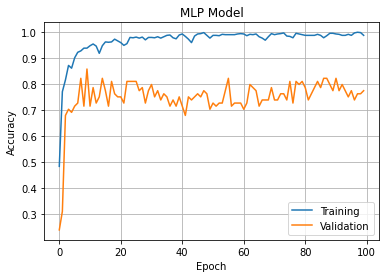

In [12]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Model')
plt.savefig('mlp_accuracy_si.svg')

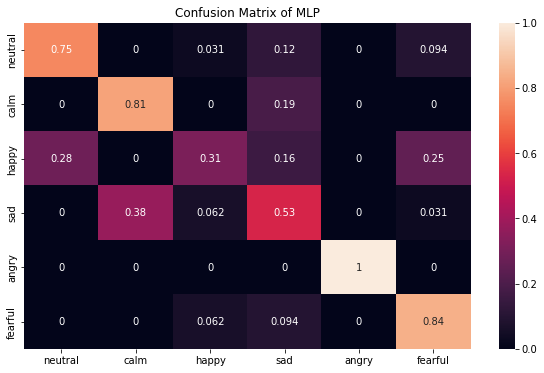

In [13]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of MLP')
sns.heatmap(cm_df, annot=True)
plt.savefig('mlp_cm_si.svg')

In [14]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.7083333333333334
